This is a supervised classification example taken from the KDD 2009 cup.  A copy of the data and details can be found here: [https://github.com/WinVector/PDSwR2/tree/master/KDD2009](https://github.com/WinVector/PDSwR2/tree/master/KDD2009).  The problem was to predict account cancellation ("churn") from very messy data (column names not given, numeric and categorical variables, many missing values, some categorical variables with a large number of possible levels).  In this example we show how to quickly use `vtreat` to prepare the data for modeling.  `vtreat` takes in `Pandas` `DataFrame`s and returns both a treatment plan and a clean `Pandas` `DataFrame` ready for modeling.


Load our packages/modules.

In [1]:
import os
import pandas
import xgboost
import vtreat
import vtreat.cross_plan
import numpy.random
import wvpy.util
import scipy.sparse

In [2]:
vtreat.__version__

'1.2.3'

Read in explanatory variables.

In [3]:
# data from https://github.com/WinVector/PDSwR2/tree/master/KDD2009
data_dir = "../../../PracticalDataScienceWithR2nd/PDSwR2/KDD2009/"
d = pandas.read_csv(
    os.path.join(data_dir, 'orange_small_train.data.gz'),
    sep='\t',
    header=0)
orig_vars = list(d.columns)
d.shape

(50000, 230)

Read in dependent variable we are trying to predict.

In [4]:
churn = pandas.read_csv(
    os.path.join(data_dir, 'orange_small_train_churn.labels.txt'),
    header=None)
churn.columns = ["churn"]
churn['churn'] = churn['churn'] == 1  # replace with True / False
churn.shape

(50000, 1)

In [5]:
churn["churn"].value_counts()

False    46328
True      3672
Name: churn, dtype: int64

Arrange test/train split.

In [6]:
numpy.random.seed(2020)
n = d.shape[0]
# https://github.com/WinVector/pyvtreat/blob/master/Examples/CustomizedCrossPlan/CustomizedCrossPlan.md
split1 = vtreat.cross_plan.KWayCrossPlanYStratified().split_plan(n_rows=n, k_folds=10, y=churn.iloc[:, 0])
train_idx = set(split1[0]['train'])
is_train = [i in train_idx for i in range(n)]
is_test = numpy.logical_not(is_train)

(The reported performance runs of this example were sensitive to the prevalance of the churn variable in the test set, we are cutting down on this source of evaluation variance by using the stratified split.)

In [7]:
d['orig_index'] = range(d.shape[0])
d_train = d.loc[is_train, :].reset_index(drop=True, inplace=False)
churn_train = numpy.asarray(churn.loc[is_train, :]["churn"])
d_test = d.loc[is_test, :].reset_index(drop=True, inplace=False)
churn_test = numpy.asarray(churn.loc[is_test, :]["churn"])

Take a look at the dependent variables.  They are a mess, many missing values.  Categorical variables that can not be directly used without some re-encoding.

In [8]:
d_train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,orig_index
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN,1
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN,2
3,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN,4
4,NaN,NaN,NaN,NaN,NaN,658.0,7.0,NaN,NaN,NaN,...,QqVuch3,LM8l689qOp,NaN,NaN,Qcbd,02N6s8f,Zy3gnGM,am7c,NaN,5


In [9]:
d_train.shape

(45000, 231)

Try building a model directly off this data (this will fail, though some systems such as xgboost can manage the categorical variables if options are set).

In [10]:
fitter = xgboost.XGBClassifier(n_estimators=10, max_depth=3, objective='binary:logistic')
try:
    fitter.fit(d_train, churn_train)
except Exception as ex:
    print(ex)

DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.Var191, Var192, Var193, Var194, Var195, Var196, Var197, Var198, Var199, Var200, Var201, Var202, Var203, Var204, Var205, Var206, Var207, Var208, Var210, Var211, Var212, Var213, Var214, Var215, Var216, Var217, Var218, Var219, Var220, Var221, Var222, Var223, Var224, Var225, Var226, Var227, Var228, Var229


/Users/johnmount/opt/anaconda3/envs/ai_academy_3_9/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Let's quickly prepare a data frame with none of these issues.

We start by building our treatment plan, this has the `sklearn.pipeline.Pipeline` interfaces.

In [11]:
plan = vtreat.BinomialOutcomeTreatment(
    outcome_target=True,
    outcome_name='churn',
    cols_to_copy=['orig_index'],
    params=vtreat.vtreat_parameters({
        'filter_to_recommended': True,
        'sparse_indicators': True,
    }))

Use `.fit_transform()` to get a special copy of the treated training data that has cross-validated mitigations against nested model bias. We call this a "cross frame." `.fit_transform()` is deliberately a different `DataFrame` than what would be returned by `.fit().transform()` (the `.fit().transform()` would damage the modeling effort due nested model bias, the `.fit_transform()` "cross frame" uses cross-validation techniques similar to "stacking" to mitigate these issues).

In [12]:
cross_frame = plan.fit_transform(d_train, churn_train)

Take a look at the new data.  This frame is guaranteed to be all numeric with no missing values, with the rows in the same order as the training data.

In [13]:
cross_frame.head()

,orig_index,Var14_is_bad,Var54_is_bad,Var44_is_bad,Var191_is_bad,Var19_is_bad,Var140_is_bad,Var70_is_bad,Var76_is_bad,Var107_is_bad,...,Var193_prevalence_code,Var193_lev_RO12,Var193_lev_2Knk1KF,Var193_lev_AERks4l,Var202_logit_code,Var202_prevalence_code,Var218_logit_code,Var218_prevalence_code,Var218_lev_cJvF,Var218_lev_UYBR
0,0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.719422,1.0,0.0,0.0,-2.924046,0.000067,-0.219613,0.506733,1.0,0.0
1,1,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.719422,1.0,0.0,0.0,0.203887,0.000067,1.265863,0.013956,0.0,0.0
2,2,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.045133,0.0,0.0,1.0,0.042491,0.001067,0.115917,0.479311,0.0,1.0
3,4,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.719422,1.0,0.0,0.0,0.154402,0.002356,0.115917,0.479311,0.0,1.0
4,5,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.144444,0.0,1.0,0.0,0.410632,0.000222,0.108131,0.479311,0.0,1.0


In [14]:
cross_frame.shape

(45000, 262)

Pick a recommended subset of the new derived variables.

In [15]:
plan.score_frame_.head()

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,R2,significance,vcount,default_threshold,recommended
0,Var14_is_bad,Var14,missing_indicator,False,True,0.016325,0.000576,2.253129e-04,193.0,0.001036,True
1,Var54_is_bad,Var54,missing_indicator,False,True,0.016358,0.000579,2.184160e-04,193.0,0.001036,True
2,Var44_is_bad,Var44,missing_indicator,False,True,-0.031791,0.002143,1.127320e-12,193.0,0.001036,True
3,Var110_is_bad,Var110,missing_indicator,False,True,0.004328,0.000037,3.487103e-01,193.0,0.001036,False
4,Var191_is_bad,Var191,missing_indicator,False,True,0.015688,0.000535,3.813099e-04,193.0,0.001036,True


In [16]:
rec = plan.score_frame_.loc[plan.score_frame_.recommended, :]
rec.treatment.value_counts()

missing_indicator    124
indicator_code        63
logit_code            31
prevalence_code       30
clean_copy            13
Name: treatment, dtype: int64

In [17]:
model_vars = numpy.asarray(plan.score_frame_["variable"][plan.score_frame_["recommended"]])
len(model_vars)

261

Fit the model

In [18]:
cross_frame.dtypes

orig_index                               int64
Var14_is_bad                           float64
Var54_is_bad                           float64
Var44_is_bad                           float64
Var191_is_bad                          float64
                                  ...         
Var202_prevalence_code                 float64
Var218_logit_code                      float64
Var218_prevalence_code                 float64
Var218_lev_cJvF           Sparse[float64, 0.0]
Var218_lev_UYBR           Sparse[float64, 0.0]
Length: 262, dtype: object

In [19]:
# used to fail due to sparse columns
# can also work around this by setting the vtreat parameter 'sparse_indicators' to False
try:
    cross_sparse = xgboost.DMatrix(data=cross_frame.loc[:, model_vars], label=churn_train)
except Exception as ex:
    print(ex)


In [20]:
# works
cross_sparse = scipy.sparse.hstack([scipy.sparse.csc_matrix(cross_frame[[vi]]) for vi in model_vars])

In [21]:
# https://xgboost.readthedocs.io/en/latest/python/python_intro.html
fd = xgboost.DMatrix(
    data=cross_sparse, 
    label=churn_train)

In [22]:
x_parameters = {"max_depth":3, "objective":'binary:logistic', "eval_metric": 'logloss'}
cv = xgboost.cv(x_parameters, fd, num_boost_round=100, verbose_eval=False)

In [23]:
cv.head()

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.504877,0.000578,0.505215,0.000469
1,0.403280,0.000908,0.403873,0.000906
2,0.342651,0.001112,0.343516,0.001245
3,0.304941,0.001207,0.305867,0.001540
4,0.280804,0.001457,0.282171,0.001653


In [24]:
best = cv.loc[cv["test-logloss-mean"]<= min(cv["test-logloss-mean"] + 1.0e-9), :]
best



,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
33,0.221068,0.001739,0.234229,0.002525


In [25]:
ntree = best.index.values[0]
ntree

33

In [26]:
fitter = xgboost.XGBClassifier(n_estimators=ntree, max_depth=3, objective='binary:logistic')
fitter

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=3,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=33, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [27]:
model = fitter.fit(cross_sparse, churn_train)

/Users/johnmount/opt/anaconda3/envs/ai_academy_3_9/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:51:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Apply the data transform to our held-out data.

In [28]:
test_processed = plan.transform(d_test)

Plot the quality of the model on training data (a biased measure of performance).

<Figure size 432x288 with 0 Axes>

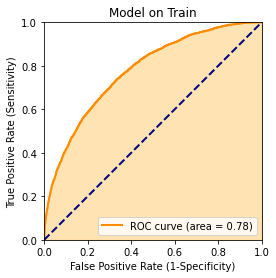

0.7774096062063185

In [29]:
pf_train = pandas.DataFrame({"churn":churn_train})
pf_train["pred"] = model.predict_proba(cross_sparse)[:, 1]
wvpy.util.plot_roc(pf_train["pred"], pf_train["churn"], title="Model on Train")

Plot the quality of the model score on the held-out data.  This AUC is not great, but in the ballpark of the original contest winners.

<Figure size 432x288 with 0 Axes>

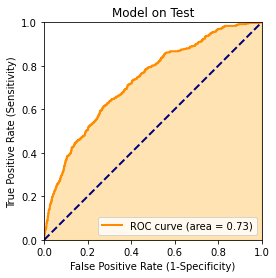

0.7303385514960742

In [30]:
test_sparse = scipy.sparse.hstack([scipy.sparse.csc_matrix(test_processed[[vi]]) for vi in model_vars])
pf = pandas.DataFrame({"churn":churn_test})
pf["pred"] = model.predict_proba(test_sparse)[:, 1]
wvpy.util.plot_roc(pf["pred"], pf["churn"], title="Model on Test")

Notice we dealt with many problem columns at once, and in a statistically sound manner. More on the `vtreat` package for Python can be found here: [https://github.com/WinVector/pyvtreat](https://github.com/WinVector/pyvtreat).  Details on the `R` version can be found here: [https://github.com/WinVector/vtreat](https://github.com/WinVector/vtreat).

We can compare this to the [R solution (link)](https://github.com/WinVector/PDSwR2/blob/master/KDD2009/KDD2009vtreat.md).

We can compare the above cross-frame solution to a naive "design transform and model on the same data set" solution as we show below.  Note we are leaveing filter to recommended on, to show the non-cross validated methodology still fails in an "easy case."

In [31]:
plan_naive = vtreat.BinomialOutcomeTreatment(
    outcome_target=True,              
    params=vtreat.vtreat_parameters({'filter_to_recommended':True}))
plan_naive.fit(d_train, churn_train)
naive_frame = plan_naive.transform(d_train)

/Users/johnmount/Documents/work/pyvtreat/pkg/vtreat/vtreat_api.py:356: UserWarning: possibly called transform on same data used to fit
(this causes over-fit, please use fit_transform() instead)
  warnings.warn(


In [32]:
model_vars = numpy.asarray(plan_naive.score_frame_["variable"][plan_naive.score_frame_["recommended"]])
len(model_vars)

257

In [33]:
naive_sparse = scipy.sparse.hstack([scipy.sparse.csc_matrix(naive_frame[[vi]]) for vi in model_vars])

In [34]:
fd_naive = xgboost.DMatrix(data=naive_sparse, label=churn_train)
x_parameters = {"max_depth":3, "objective":'binary:logistic'}
cvn = xgboost.cv(x_parameters, fd_naive, num_boost_round=100, verbose_eval=False)

[13:52:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

In [35]:
bestn = cvn.loc[cvn["test-logloss-mean"] <= min(cvn["test-logloss-mean"] + 1.0e-9), :]
bestn

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
98,0.116698,0.001266,0.137995,0.001881


In [36]:
ntreen = bestn.index.values[0]
ntreen

98

In [37]:
fittern = xgboost.XGBClassifier(n_estimators=ntreen, max_depth=3, objective='binary:logistic')
fittern

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=3,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=98, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [38]:
modeln = fittern.fit(naive_sparse, churn_train)

/Users/johnmount/opt/anaconda3/envs/ai_academy_3_9/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:52:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [39]:
test_processedn = plan_naive.transform(d_test)
test_processedn = scipy.sparse.hstack([scipy.sparse.csc_matrix(test_processedn[[vi]]) for vi in model_vars])

<Figure size 432x288 with 0 Axes>

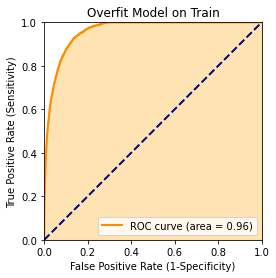

0.9604501873589704

In [40]:
pfn_train = pandas.DataFrame({"churn":churn_train})
pfn_train["pred_naive"] = modeln.predict_proba(naive_sparse)[:, 1]
wvpy.util.plot_roc(pfn_train["pred_naive"], pfn_train["churn"], title="Overfit Model on Train")

<Figure size 432x288 with 0 Axes>

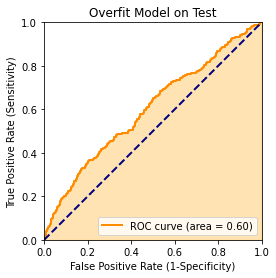

0.5998324008288668

In [41]:
pfn = pandas.DataFrame({"churn":churn_test})
pfn["pred_naive"] = modeln.predict_proba(test_processedn)[:, 1]
wvpy.util.plot_roc(pfn["pred_naive"], pfn["churn"], title="Overfit Model on Test")

Note the naive test performance is worse, despite its far better training performance.  This is over-fit due to the nested model bias of using the same data to build the treatment plan and model without any cross-frame mitigations.


## Additional experiments

### data_algebra pipeline

In [42]:
from data_algebra.data_ops import descr, TableDescription
import vtreat.vtreat_db_adapter

transform_as_data = plan.description_matrix()

transform_as_data

,treatment_class,treatment,orig_var,orig_was_numeric,variable,value,replacement
0,IndicateMissingTransform,missing_indicator,Var14,True,Var14_is_bad,_NA_,1.000000
1,IndicateMissingTransform,missing_indicator,Var54,True,Var54_is_bad,_NA_,1.000000
2,IndicateMissingTransform,missing_indicator,Var44,True,Var44_is_bad,_NA_,1.000000
3,IndicateMissingTransform,missing_indicator,Var110,True,Var110_is_bad,_NA_,1.000000
4,IndicateMissingTransform,missing_indicator,Var191,False,Var191_is_bad,_NA_,1.000000
...,...,...,...,...,...,...,...
135865,MappedCodeTransform,prevalence_code,Var218,False,Var218_prevalence_code,UYBR,0.479311
135866,MappedCodeTransform,prevalence_code,Var218,False,Var218_prevalence_code,_NA_,0.013956
135867,MappedCodeTransform,prevalence_code,Var218,False,Var218_prevalence_code,cJvF,0.506733
135868,IndicatorCodeTransform,indicator_code,Var218,False,Var218_lev_cJvF,cJvF,1.000000


In [43]:
incoming_vars = list(set(transform_as_data['orig_var']))

ops = vtreat.vtreat_db_adapter.as_data_algebra_pipeline(
    source=TableDescription(
        table_name='d_test',
        column_names=incoming_vars+ ['orig_index']),
    vtreat_descr=transform_as_data,
    treatment_table_name='transform_as_data',
    row_keys=['orig_index'],
)

test_by_pipeline = ops.eval({
    'd_test': d_test.loc[:, incoming_vars + ['orig_index']],
    'transform_as_data': transform_as_data})

In [44]:
assert test_by_pipeline.shape[0] == test_processed.shape[0]

In [45]:
assert test_by_pipeline.shape[1] >= test_processed.shape[1]

In [46]:
assert not numpy.any(numpy.isnan(test_by_pipeline))

In [47]:
test_pipeline_cols = set(test_by_pipeline.columns)
assert numpy.all([c in test_pipeline_cols for c in test_processed.columns])


In [48]:
test_cols_sorted = list(test_processed.columns)
test_cols_sorted.sort()
assert numpy.max(numpy.max(numpy.abs(test_processed[test_cols_sorted] - test_by_pipeline[test_cols_sorted]))) < 1e-5


### data algebra pipeline in database

In [49]:
import data_algebra.BigQuery


In [50]:
db_handle = data_algebra.BigQuery.example_handle()

db_handle.drop_table('d_test_processed')
db_handle.insert_table(d_test.loc[:, incoming_vars + ['orig_index']], table_name='d_test', allow_overwrite=True)
_ = db_handle.insert_table(transform_as_data, table_name='transform_as_data', allow_overwrite=True)

In [51]:
db_handle.execute(
    f"CREATE TABLE {db_handle.db_model.table_prefix}.d_test_processed AS {db_handle.to_sql(ops)}")

In [52]:
db_res = db_handle.read_query(
    f"SELECT * FROM {db_handle.db_model.table_prefix}.d_test_processed ORDER BY orig_index")

db_res

,Var206_lev_hAFG,Var180_is_bad,Var82_is_bad,Var228_lev_xwM2aC7IdeMC0,Var223_is_bad,Var198_lev_fhk21Ss,Var221_lev_QKW8DRm,Var88_is_bad,Var218_prevalence_code,Var195_prevalence_code,...,Var106,Var56,Var162,Var17,Var60,Var123,Var184,Var93,Var126,Var75
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.479311,0.959511,...,38336.457983,91249.288136,345790.896861,11.512605,9.878491,0.000000,8.839462,2.119245,-14.000000,6.470852
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.506733,0.959511,...,38336.457983,91249.288136,345790.896861,11.512605,9.878491,102.000000,8.839462,2.119245,8.000000,6.470852
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.506733,0.959511,...,38336.457983,91249.288136,345790.896861,11.512605,9.878491,0.000000,8.839462,2.119245,-0.587949,6.470852
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.479311,0.959511,...,38336.457983,91249.288136,345790.896861,11.512605,9.878491,30.000000,8.839462,2.119245,14.000000,6.470852
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.506733,0.959511,...,38336.457983,91249.288136,345790.896861,11.512605,9.878491,0.000000,8.839462,2.119245,22.000000,6.470852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.479311,0.959511,...,38336.457983,91249.288136,345790.896861,11.512605,9.878491,72.000000,8.839462,2.119245,-0.587949,6.470852
4996,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.506733,0.959511,...,38336.457983,91249.288136,345790.896861,11.512605,9.878491,59.877648,8.839462,2.119245,-20.000000,6.470852
4997,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.506733,0.959511,...,38336.457983,91249.288136,345790.896861,11.512605,9.878491,6.000000,8.839462,2.119245,-22.000000,6.470852
4998,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.479311,0.959511,...,38336.457983,91249.288136,345790.896861,11.512605,9.878491,66.000000,8.839462,2.119245,-30.000000,6.470852


In [53]:
assert db_res.shape[0] == test_processed.shape[0]

In [54]:
assert numpy.max(numpy.max(numpy.abs(test_processed[test_cols_sorted] - db_res[test_cols_sorted]))) < 1e-5


In [55]:
db_handle.drop_table('d_test')
db_handle.drop_table('transform_as_data')
db_handle.drop_table('d_test_processed')
db_handle.close()
